### Segmentation of a blood vessel dataset

This code uses torchtrainer, a package that contains some utility functions for creating datasets, network architectures and calculating performance metrics. You can download the package at:

[https://github.com/chcomin/torchtrainer](https://github.com/chcomin/torchtrainer)

You can put the folder containing the package (torchtrainer) in the same directory as this notebook, or install the package by running the following command:

`pip install -e torchtrainer`

or if using conda:

`conda develop torchtrainer`

where `torchtrainer` is the directory containing the `pyproject.toml` file.


To download the dataset, run the following cell:

In [1]:
#from dataset_vessel import download
#download(directory='data')

100%|██████████| 4448948/4448948 [00:02<00:00, 2096032.12it/s]


Extracting data\VessMAP.zip to data/vessmap


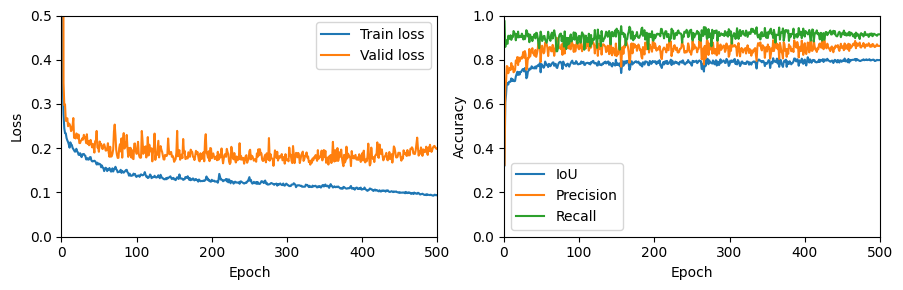

In [1]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import train_vessel
import torchtrainer

params = {
    # Dataset
    'img_dir': Path('data/vessmap/images'),     # Images path
    'label_dir': Path('data/vessmap/annotator1/labels'),   # Labels path   
    'train_val_split': 0.1,                    # Train/validation split
    'transform_type': 'train-geometric',       # Which data augmentation to use
    # Model
    'model_layers': (8,),                      # Number of residual blocks at each layer of the model
    'model_channels': (64,),                   # Number of channels at each layer
    'decoder_layers': (1,),
    'model_type': 'unetv2',                    # Model to use
    # Training
    'epochs': 500,
    'lr': 0.01,
    'batch_size_train': 10,
    'batch_size_valid': 10, 
    'momentum': 0.9,                           # Momentum for optimizer
    'weight_decay': 0.1,
    'seed': 12,                                # Seed for random number generators
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,                    # Power por the polynomial scheduler
    'class_weights': (0.2590, 0.7410),         # Class weights to use for cross entropy calculation
    # Efficiency
    'device': 'cuda',
    'num_workers': 0,                          # Number of workers for the dataloader
    'use_amp': False,                          # Mixed precision
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': 'logs/',                        # Directory for logging metrics and model checkpoints
    'experiment':'unetv2_l_8_c_64',            # Experiment tag
    'save_every':1,                            # Number of epochs between checkpoints     
    'save_best':True,                          # Save model with best validation loss
    'meta': None,                              # Additional metadata to save
    # Other 
    'resume': False                            # Resume from previous training
}

logger, ds_train, ds_valid, model = train_vessel.run(params)

### View results

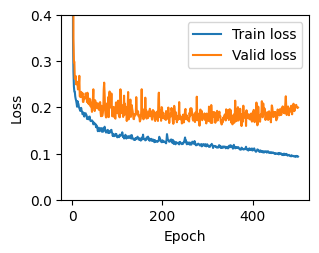

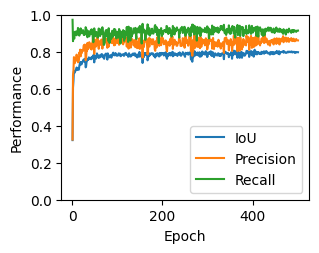

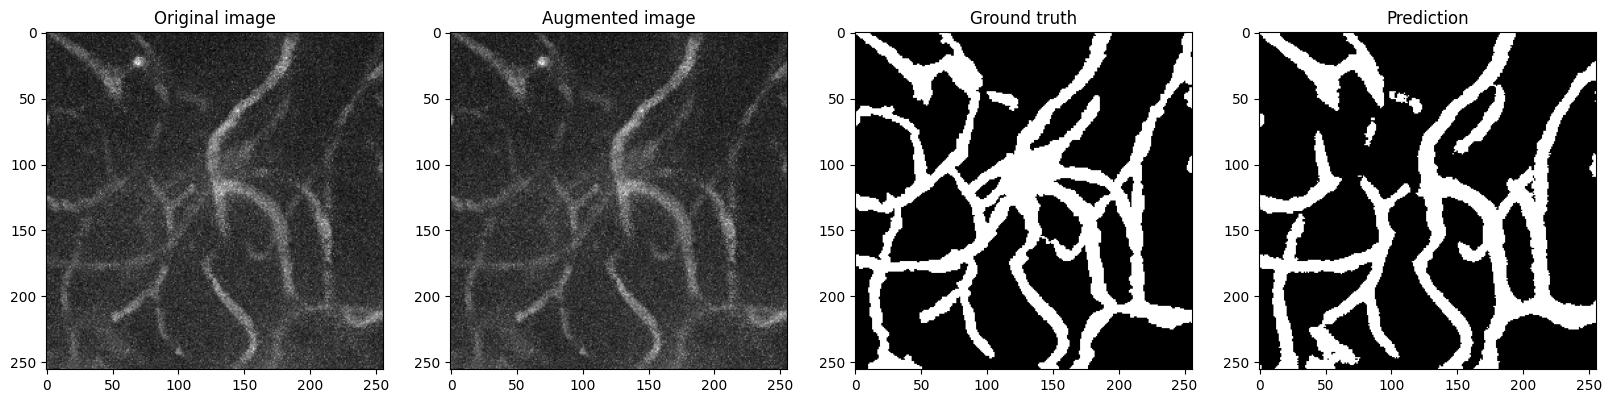

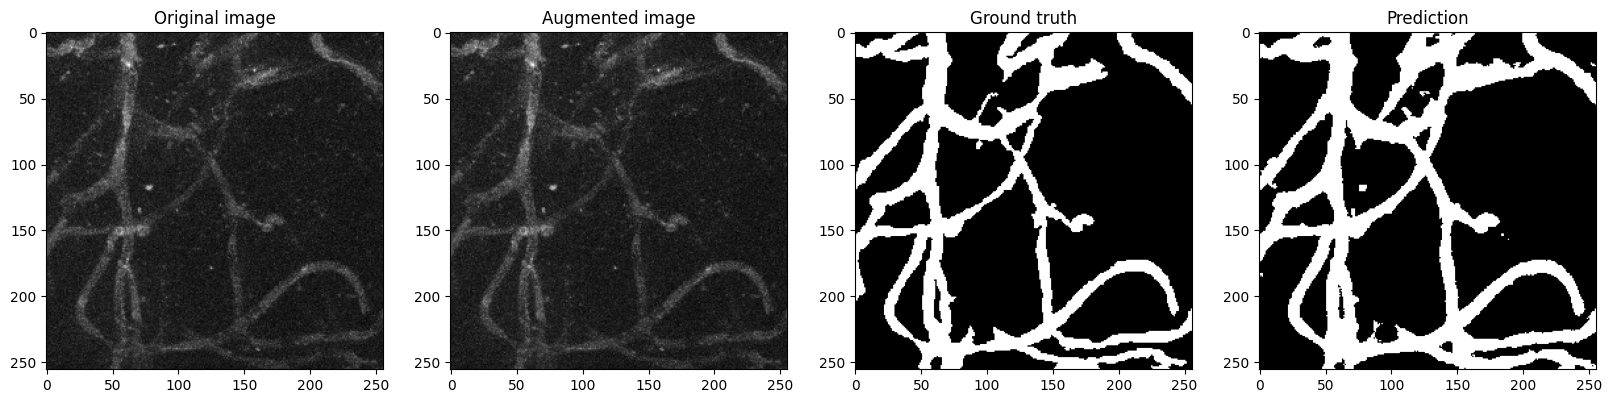

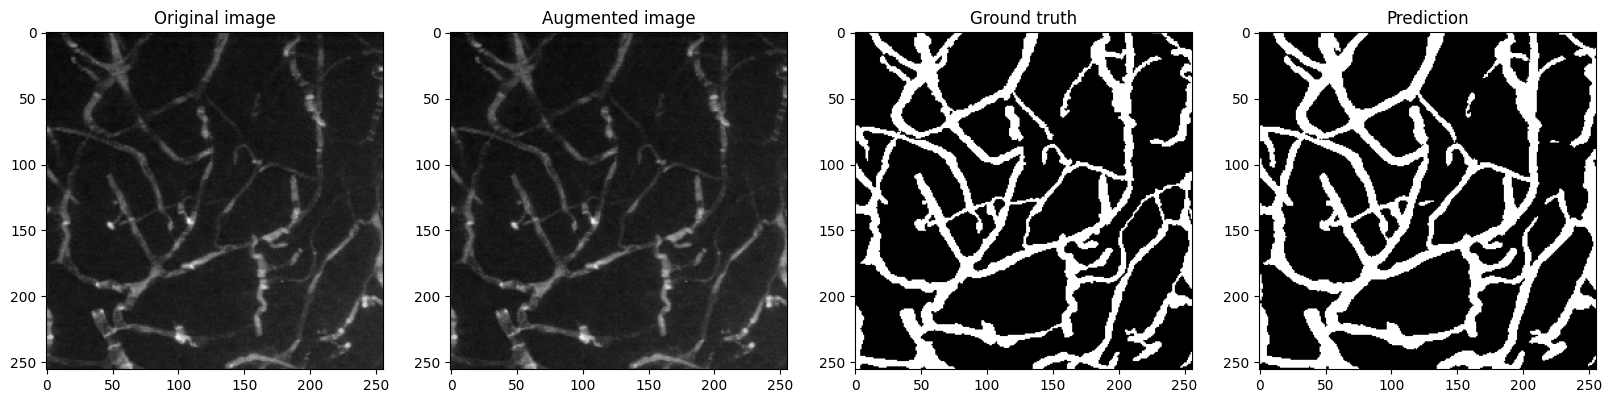

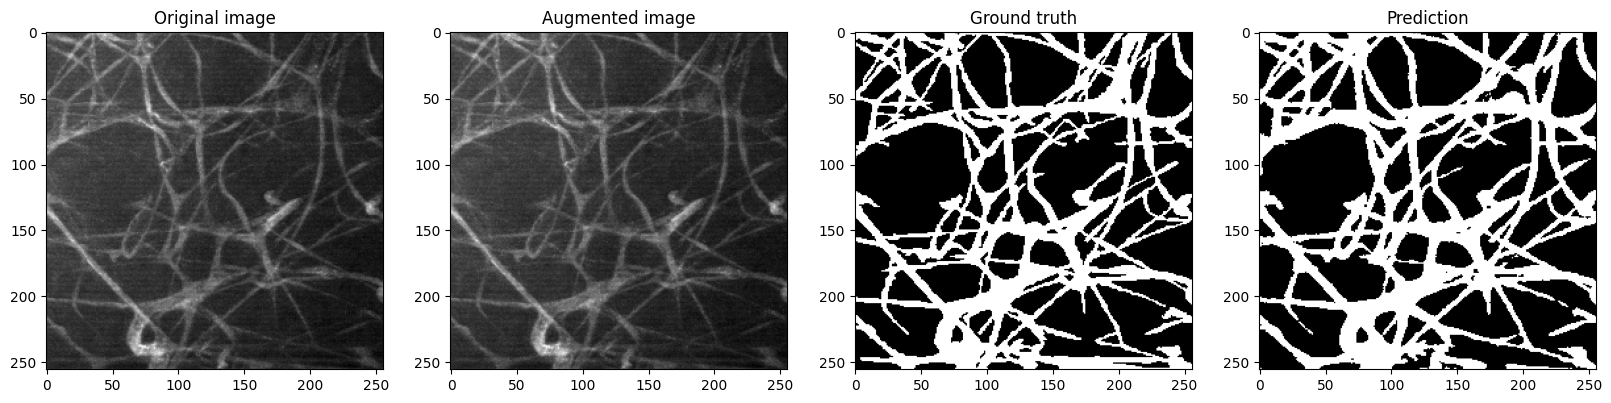

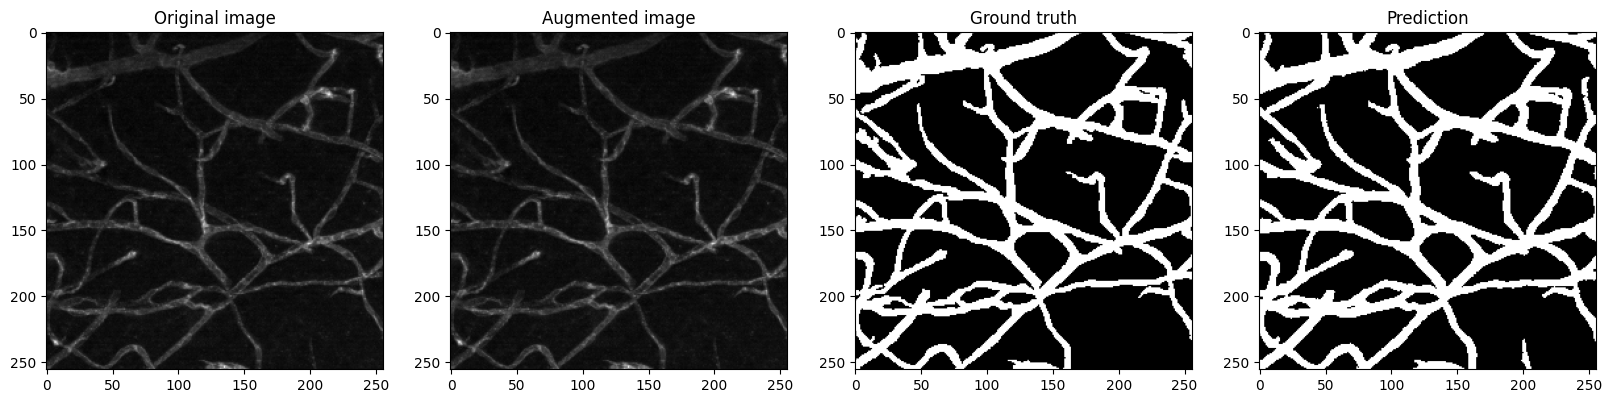

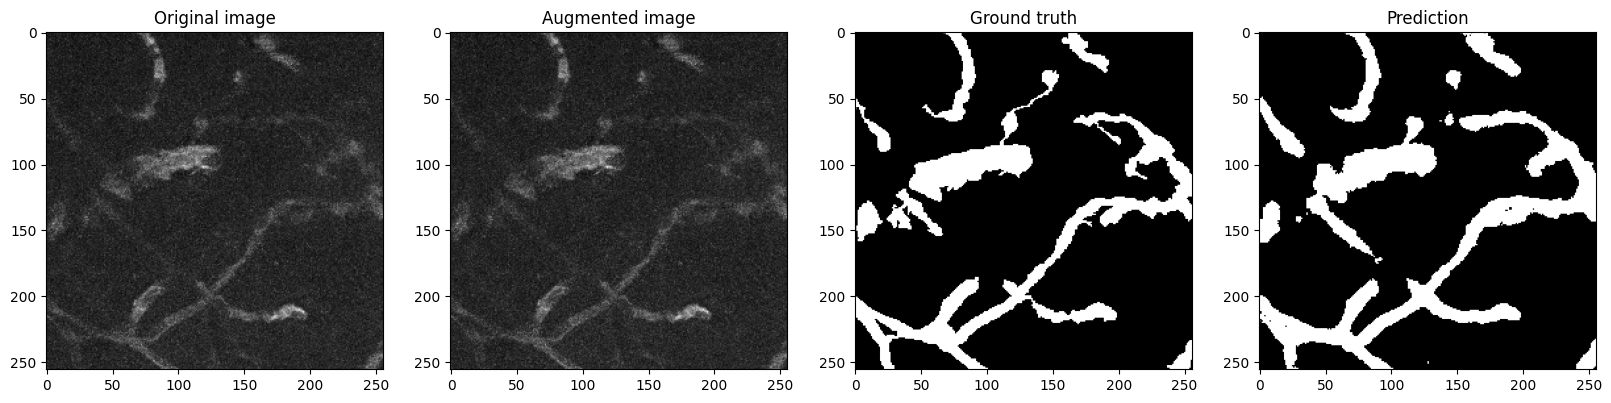

In [5]:
# Plot results
def plot_metrics(logger):
    '''Plot losses and IoU.''' 
    
    epochs, metrics = zip(*logger.data.items())
    train_loss, valid_loss, iou, prec, rec = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0., 0.4))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0., 1.))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=6):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)  # Randomly draw some indices
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

plot_metrics(logger)
plot_examples(ds_valid, model)

### Analyze model statistics

In [6]:
# Check if output values are too large
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        output = model(x[None].to('cuda'))[0].to('cpu')
        stats.append((idx, output.min().item(), output.max().item()))
print('Batch index, min val, max val')
stats

Batch index, min val, max val


[(0, -9.797832489013672, 10.841830253601074),
 (1, -10.389328956604004, 10.32152271270752),
 (2, -12.140350341796875, 12.175251007080078),
 (3, -10.195954322814941, 11.019134521484375),
 (4, -10.783102989196777, 11.169449806213379),
 (5, -9.892997741699219, 9.944478034973145),
 (6, -13.342206001281738, 13.284416198730469),
 (7, -14.06979751586914, 14.268345832824707),
 (8, -14.695317268371582, 14.512739181518555),
 (9, -14.477190017700195, 14.369670867919922)]

In [7]:
# Check performance
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        output = model(x[None].to('cuda')).to('cpu')
        acc = torchtrainer.perf_funcs.segmentation_accuracy(output, y[None], ('iou', 'prec', 'rec'))
        stats.append((idx, *list(acc.items())))
print('Batch index, batch metrics')
stats

Batch index, batch metrics


[(0,
  ('iou', tensor(0.7050)),
  ('prec', tensor(0.8569)),
  ('rec', tensor(0.7990))),
 (1,
  ('iou', tensor(0.7496)),
  ('prec', tensor(0.7977)),
  ('rec', tensor(0.9256))),
 (2,
  ('iou', tensor(0.7840)),
  ('prec', tensor(0.8053)),
  ('rec', tensor(0.9674))),
 (3,
  ('iou', tensor(0.7728)),
  ('prec', tensor(0.8319)),
  ('rec', tensor(0.9157))),
 (4,
  ('iou', tensor(0.8360)),
  ('prec', tensor(0.9154)),
  ('rec', tensor(0.9060))),
 (5,
  ('iou', tensor(0.8136)),
  ('prec', tensor(0.9246)),
  ('rec', tensor(0.8714))),
 (6,
  ('iou', tensor(0.8447)),
  ('prec', tensor(0.8724)),
  ('rec', tensor(0.9638))),
 (7,
  ('iou', tensor(0.8347)),
  ('prec', tensor(0.8630)),
  ('rec', tensor(0.9623))),
 (8,
  ('iou', tensor(0.8189)),
  ('prec', tensor(0.8709)),
  ('rec', tensor(0.9320))),
 (9,
  ('iou', tensor(0.8024)),
  ('prec', tensor(0.8313)),
  ('rec', tensor(0.9584)))]

In [9]:
# Check intermediate activations of the model
insp = torchtrainer.inspector.Inspector(model)
insp.start_tracking_activations()

model.eval()
model.to('cuda')
with torch.no_grad():
    output = model(ds_valid[0][0][None].to('cuda'))
acts = insp.get_activations()

stats = []
for k, v in acts:
    if v is not None:
        stats.append((k, v.min(), v.max()))
stats

[('resunetv2.stage_input.0', tensor(-8.1445), tensor(5.7351)),
 ('resunetv2.stage_input.1', tensor(-9.4782), tensor(8.6093)),
 ('resunetv2.encoder.stage_0.0.conv1', tensor(-10.6199), tensor(4.8874)),
 ('resunetv2.encoder.stage_0.0.bn1', tensor(-3.9021), tensor(2.8622)),
 ('resunetv2.encoder.stage_0.0.conv2', tensor(-3.5809), tensor(2.5359)),
 ('resunetv2.encoder.stage_0.0.bn2', tensor(-2.0762), tensor(1.3856)),
 ('resunetv2.encoder.stage_0.0.residual_adj.0',
  tensor(-2.1821),
  tensor(1.3362)),
 ('resunetv2.encoder.stage_0.0.residual_adj.1',
  tensor(-3.1051),
  tensor(1.8259)),
 ('resunetv2.encoder.stage_0.0', tensor(0.), tensor(1.8441)),
 ('resunetv2.encoder.stage_0.1.conv1', tensor(-2.4871), tensor(1.7740)),
 ('resunetv2.encoder.stage_0.1.bn1', tensor(-1.6698), tensor(0.9424)),
 ('resunetv2.encoder.stage_0.1.conv2', tensor(-1.3912), tensor(1.1507)),
 ('resunetv2.encoder.stage_0.1.bn2', tensor(-1.3140), tensor(1.2792)),
 ('resunetv2.encoder.stage_0.1', tensor(0.), tensor(1.7885)),
 

In [2]:
# Benchmark model

_model = torchtrainer.models.resunet.ResUNetV2((8,), (64,), (1,))
tensor_shape = (10, 1, 256, 256)
stats_train = torchtrainer.profiling.benchmark_model(_model, tensor_shape, no_grad=False, call_backward=True, use_float16=True, return_model_info=False)
stats_val = torchtrainer.profiling.benchmark_model(_model, tensor_shape, no_grad=True, call_backward=False, use_float16=True, return_model_info=False)
print(stats_train)
print(stats_val)

{'params': 0.0, 'activations': 0.0, 'flops': 0.0, 'memory': 0.3337688446044922, 'time_cpu': 0.05000185966491699, 'time_gpu': 0.12308889770507812, 'info': ['params: M', 'activations: G', 'flops: G', 'memory: GiB', 'time_cpu: s', 'time_gpu: s']}
{'params': 0.0, 'activations': 0.0, 'flops': 0.0, 'memory': 0.007395267486572266, 'time_cpu': 0.024003267288208008, 'time_gpu': 0.031438848495483396, 'info': ['params: M', 'activations: G', 'flops: G', 'memory: GiB', 'time_cpu: s', 'time_gpu: s']}
